In [5]:
# Importations
import pandas as pd
import warnings
import numpy as np
import gensim

import torch
import torch.nn as nn

warnings.filterwarnings('ignore')

### Data processing

In [6]:
df = pd.read_csv("entities.csv", sep='delimiter', header=None)
df = df[0].str.split(',', expand=True)

In [7]:
df = df.iloc[1:, :2].reset_index(drop=True).rename(columns={0:"text", 1:'label'})

df = df.loc[(df['text'].str.len() > 20) & (df['text'].str.len() < 80)]

df.loc[df['label'] == 'True', 'label'] = 1
df.loc[df['label'] == 'False', 'label'] = 0

df = df.loc[df['label'].isin([0,1])]
df['label'] = df['label'].astype(np.float32)

# On se ramène a l'implémentation de Hugging Face
texts = list(df['text'])
labels = list(df['label'])


In [8]:
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=.1)
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.2)

In [9]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
train_labels_encoded = encoder.fit_transform(np.array(train_labels).reshape(-1,1))
test_labels_encoded = encoder.fit_transform(np.array(test_labels).reshape(-1,1))
val_labels_encoded = encoder.fit_transform(np.array(val_labels).reshape(-1,1))

### Stats descriptives

In [13]:
df.loc[df['label'] == 1].head(50)

,text,label
1,Ferazzi Auguste vitrier 30 Garçon Piémontaise,1.0
2,Machol Pierre vitrier 24 Garçon Piémontaise,1.0
3,Desbois Alexandre prop re 48 Homme marié franç...,1.0
7,Desbroper François Jules aumônier du collège 4...,1.0
9,de Chaumont 40 Homme marié française,1.0
15,Allemant Philippe tailleur 45 Homme marié fran...,1.0
17,Gaucheron Joachim Florentin pharmacien 30 Homm...,1.0
23,des Tureaux Henri courtier de commerce 32 Homm...,1.0
27,Paulin Michel Jean agent doyen en chef 48 Homm...,1.0
30,Moullier Abel Emile employé 27 Homme marié fra...,1.0


### Model CamemBert

In [ ]:
from transformers import CamembertTokenizer
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [ ]:
train_labels_encoded = train_labels_encoded.astype(np.float32)

In [ ]:
import torch

class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = IMDbDataset(train_encodings, train_labels_encoded)
val_dataset = IMDbDataset(val_encodings, val_labels_encoded)
test_dataset = IMDbDataset(test_encodings, test_labels_encoded)

In [ ]:
from torch.utils.data import DataLoader
from transformers import CamembertForSequenceClassification, AdamW

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = CamembertForSequenceClassification.from_pretrained('camembert-base')
model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

train_error = []
val_error = []

batch_size = 256

for epoch in range(15):
    print(epoch)
    
    epoch_average_loss_test = 0
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        epoch_average_loss_test += loss.item() * batch_size / len(val_loader)
    val_error.append(epoch_average_loss_test)
    
    epoch_average_loss_train = 0
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()
        epoch_average_loss_train += loss.item() * batch_size / len(train_loader)
    train_error.append(epoch_average_loss_train)


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


Text(0.5, 1.0, 'Visualization of convergence')

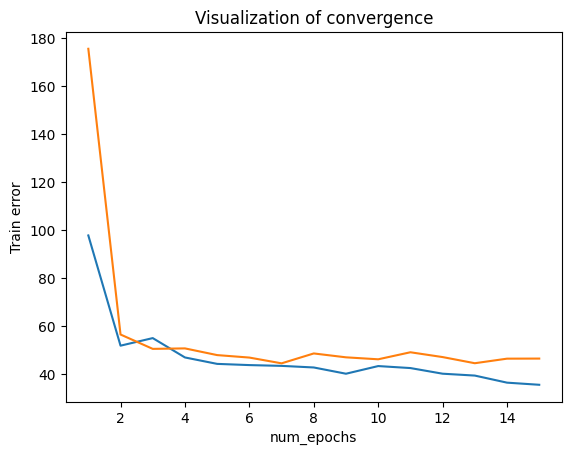

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(train_error) + 1), train_error)
plt.plot(range(1, len(train_error) + 1), val_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

correct = 0

for batch in test_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, labels=labels).logits
    outputs = torch.tensor(outputs > 0, dtype=torch.float32).to(device)
    correct += (outputs == batch['labels'].to(device)).sum() / 2

print(f'Accuracy: {round(correct.item()/len(test_loader)*100, 2)}%')

Accuracy: 92.8%


### model Word2Vec + RandomForest

In [ ]:
# Clean data using the built in cleaner in gensim
df['text_clean'] = df['text'].apply(lambda x: gensim.utils.simple_preprocess(x))
df

,text,label,text_clean
0,Breton Cyrille menuisier 25 Garçon française,0.0,"[breton, cyrille, menuisier, garçon, française]"
1,Ferazzi Auguste vitrier 30 Garçon Piémontaise,1.0,"[ferazzi, auguste, vitrier, garçon, piémontaise]"
2,Machol Pierre vitrier 24 Garçon Piémontaise,1.0,"[machol, pierre, vitrier, garçon, piémontaise]"
3,Desbois Alexandre prop re 48 Homme marié française,1.0,"[desbois, alexandre, prop, re, homme, marié, française]"
4,Vignat Zélie prop re sa fe 30 française,0.0,"[vignat, zélie, prop, re, sa, fe, française]"
...,...,...,...
25076,Chameton-Dideron Marie chef 1869 idem Pailharès,1.0,"[chameton, dideron, marie, chef, idem, pailharès]"
25077,Ode Marie ouv chaus res chef Cara 1863 idem St Naz en Royans,1.0,"[ode, marie, ouv, chaus, res, chef, cara, idem, st, naz, en, royans]"
25078,Berni Nello manoeuvre chef Baretto 1886 italienne Castel,1.0,"[berni, nello, manoeuvre, chef, baretto, italienne, castel]"
25079,Berni-Laureti Annunziata épouse 1887 idem idem,0.0,"[berni, laureti, annunziata, épouse, idem, idem]"


In [ ]:
# Encoding the label column
X_train, X_test, y_train, y_test = train_test_split (df['text_clean'], df['label'] , test_size=0.2)

In [ ]:
# Train the word2vec model
w2v_model = gensim.models.Word2Vec(X_train,
                                   vector_size=100,
                                   window=5,
                                   min_count=2)

In [ ]:
words = set(w2v_model.wv.index_to_key)
X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_train], dtype="object")
X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_test], dtype="object")

In [ ]:
# Compute sentence vectors by averaging the word vectors for the words contained in the sentence
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))
        
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))

In [ ]:
(y_train.notna()).sum()

19537

In [ ]:
# Instantiate and fit a basic Random Forest model on top of the vectors
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf_model = rf.fit(X_train_vect_avg, y_train.values.ravel())

In [ ]:
# Use the trained model to make predictions on the test data
y_pred = rf_model.predict(X_test_vect_avg)

In [ ]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Precision: 0.786 / Recall: 0.848 / Accuracy: 0.913


### References

For the first model, we followed the tutorial of hugging face given in the professor's website.

For the second model, we followed the medium website code for using Word2Vec embedding combined with the random forest model. 

* https://huggingface.co/transformers/v3.2.0/custom_datasets.html#token-classification-with-w-nut-emerging-entities

* https://medium.com/@dilip.voleti/classification-using-word2vec-b1d79d375381
